# Testing for CuW-ACE potential

# load some packages

In [1]:
from amstools import *
from pyace import *
import shutil
import os
import glob
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
from ase import Atoms
from ase.build import bcc110, bcc100, bcc111, fcc100, fcc110, fcc111
from ase.visualize import view
from ase.build import surface, bulk
from ase.io import write, read
from collections import Counter
from pyace.preparedata import calc_min_distance,aseatoms_to_atomicenvironment
from matplotlib.colors import LinearSegmentedColormap
from math import pi

# Dataset

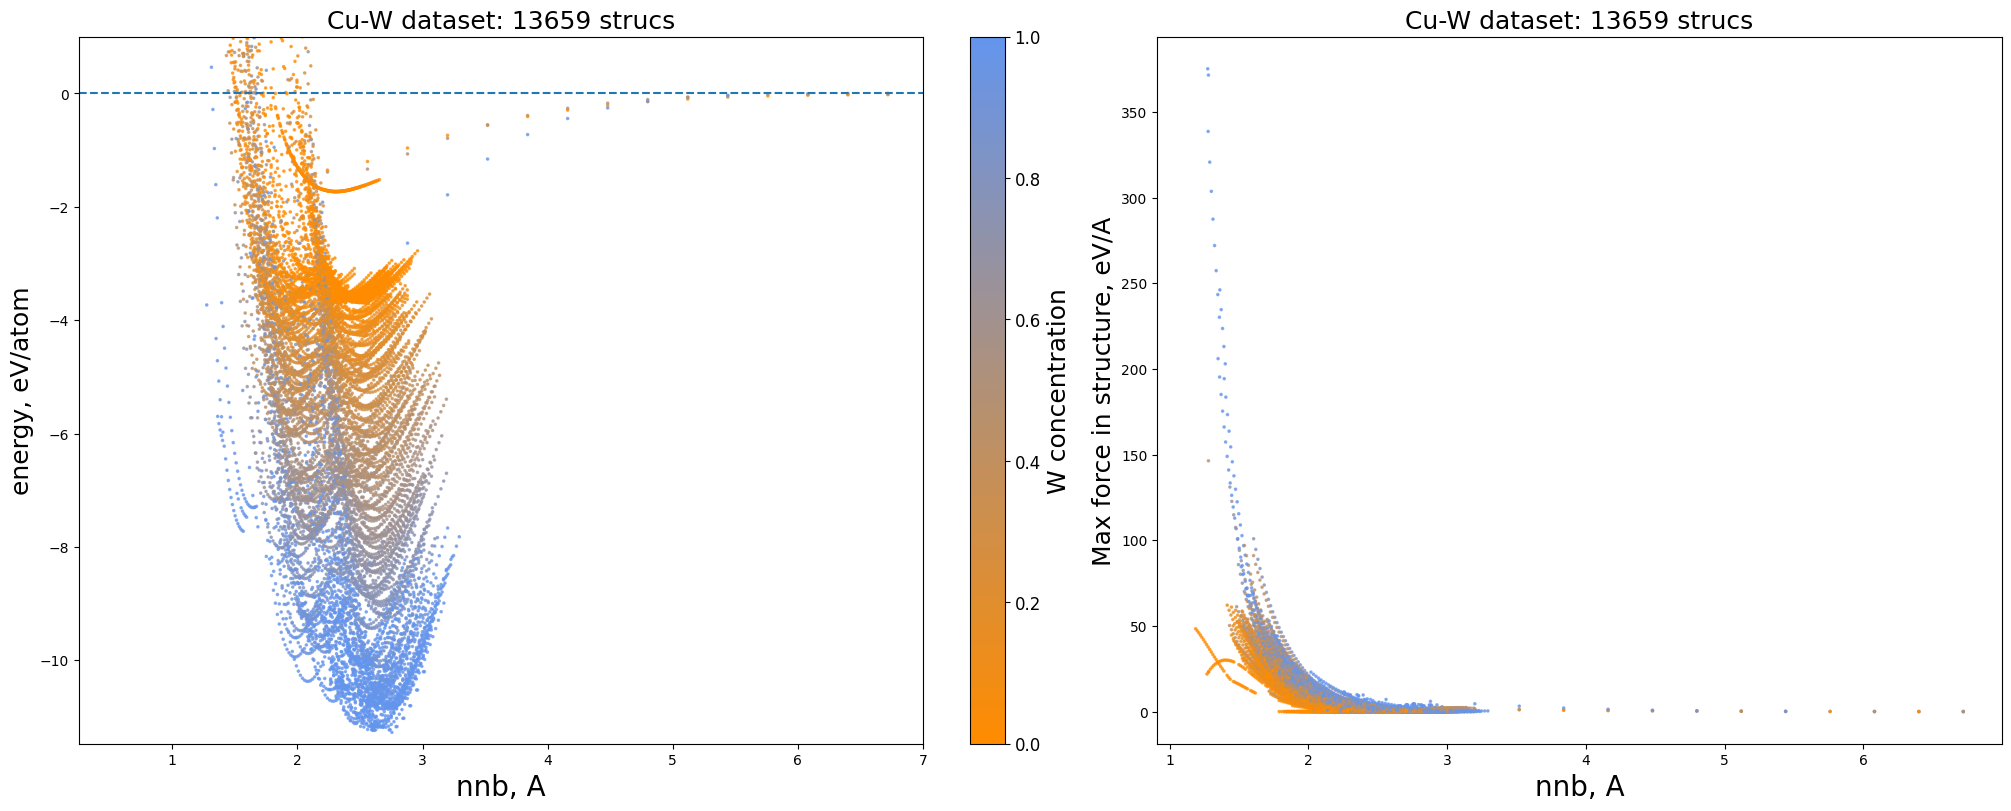

In [2]:
# Set element information
elem1 = "Cu"
elem2 = "W"
# Read the dataset
df_binary = pd.read_pickle("./dataset/CuW_all.pckl.gzip",compression="gzip")

def process_df(df, elem1=elem1, elem2=elem2):
    # single-atom energies of Cu and W (IN ORDER!)
    e0_array = np.array([-0.017568369, -1.6833144])  # Cu, W

    df["NUMBER_OF_ATOMS"] = df["ase_atoms"].map(len)

    if "energy" in df.columns:
        df["energy_per_atom"] = df["energy"] / df["NUMBER_OF_ATOMS"]

    df["comp_dict"] = df["ase_atoms"].map(lambda at: Counter(at.get_chemical_symbols()))
    df["n%s" % elem1] = df["comp_dict"].map(lambda d: d.get("%s" % elem1, 0))
    df["n%s" % elem2] = df["comp_dict"].map(lambda d: d.get("%s" % elem2, 0))
    df["c%s" % elem2] = df["n%s" % elem2] / df["NUMBER_OF_ATOMS"]
    df["c%s" % elem1] = df["n%s" % elem1] / df["NUMBER_OF_ATOMS"]

    if "energy_corrected" not in df.columns:
        df["energy_corrected"] = df["energy"] - np.sum(df[["n%s" % elem1, "n%s" % elem2]].values * e0_array, axis=1)
        df["energy_corrected_per_atom"] = df["energy_corrected"] / df["NUMBER_OF_ATOMS"]

    if "atomic_env" not in df.columns:
        df["atomic_env"] = df["ase_atoms"].apply(aseatoms_to_atomicenvironment, args=(7.,))
    df["nnb"] = df["atomic_env"].apply(calc_min_distance)


process_df(df_binary)

from matplotlib import cm
import matplotlib as mpl

def get_max_F(forces):
    return max([max(f) for f in forces])

df_binary["F"] = df_binary["forces"].apply(get_max_F)

#fig, (ax, bx) = plt.subplots(dpi=150)
fig, (ax, bx) = plt.subplots(1, 2, figsize=(20, 8), constrained_layout=True)

e0 = df_binary["energy_corrected_per_atom"].min()

colors = ['darkorange', 'cornflowerblue']
#colors = ['gold', 'blue']
n_bins = 100  # Divided into 100 colors
cmap_name = "red_to_green"
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

ax.scatter(df_binary["nnb"], df_binary["energy_corrected_per_atom"],
           marker=".",
           c=df_binary["c%s" % elem2],  # Use the value of the c%s column to map the color
           cmap=custom_cmap,  # Use custom gradient mappings
           alpha=0.7,
           s=10
           )
bx.scatter(df_binary["nnb"], df_binary["F"],
           marker=".",
           c=df_binary["c%s" % elem2],  # Use the value of the c%s column to map the color
           cmap=custom_cmap,  # Use custom gradient mappings
           alpha=0.7,
           s=10
           )

norm = mpl.colors.Normalize(df_binary["c%s" % elem2].min(), df_binary["c%s" % elem1].max())
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=custom_cmap), ax=ax)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_ylabel(r"%s concentration" % elem2, fontsize=18)

ax.axhline(0, ls="--")

ax.set_ylim(e0 - .2, 1)
ax.set_xlim(0.25, 7)

ax.set_xlabel("nnb, A", fontsize=20)
ax.set_ylabel("energy, eV/atom", fontsize=18)
ax.set_title("%s-%s dataset: %d strucs" % (elem1, elem2, len(df_binary)), fontsize=18)

bx.set_xlabel("nnb, A", fontsize=20)
bx.set_ylabel("Max force in structure, eV/A", fontsize=18)
bx.set_title("%s-%s dataset: %d strucs" % (elem1, elem2, len(df_binary)), fontsize=18)

plt.savefig("Dataset_CuW.png")
plt.show()

# Constant setting

In [3]:
# eV to J 
eV_to_J = 1.6022e-19
# eV to mJ 
eV_to_mJ = 1.6022e-16
# m to A
A_to_m = 1e-10
# eV/A3 to GPa
eV_per_A3_to_GPa=160.21773

# Potential parameter settings

In [4]:
# Parameter file
model = "./potential/output_potential4.yaml"
rcut=7.0
# Define the ASE calculator
calc = PyACECalculator(model)

# Program run folder

In [5]:
# Save starting directory
save_cwd=os.getcwd()
print("Current directory: ",save_cwd)
# Set where lammps calculations will be done
tmp_dir="./run"
# Better remove whatever is left there
shutil.rmtree(tmp_dir, ignore_errors = True)
print("Calculations will run in directory: ",tmp_dir)
if not os.path.isdir(tmp_dir):
    os.mkdir(tmp_dir)

Current directory:  /home/jiahaopan
Calculations will run in directory:  ./run


# Elemental properties test

## Cu

### Initial setup

In [6]:
# Element name and the expected equilibrium crystal structure
elm = "Cu"
equilstruc = "fcc"

### Lattice constant calculation

In [7]:
# Use ams_tools dictionary of structures
struc_tmp=get_structures_dictionary(elm, include=equilstruc)
struc_ini = struc_tmp[equilstruc]["atoms"]
# Optimize the initial structure
struc_ini.set_calculator(calc)
optimizer=SpecialOptimizer(struc_ini)
struc_opt = optimizer.run()
struc_opt.set_calculator(calc)
en_opt=struc_opt.get_potential_energy()/len(struc_opt)
E_refer_Cu = en_opt
stress_opt=struc_opt.get_stress()*eV_per_A3_to_GPa
f_opt=struc_opt.get_forces()
fmax_opt = 0
for i in f_opt:
    fval = (float(i[0])**2 + float(i[1])**2 + float(i[2])**2)**(1./2.)
    if fval > fmax_opt:
        fmax_opt = fval
lattice_opt = (struc_opt.cell.lengths()[0])*2/(2**(1/2))
#opt_information = {"opt_structure": {"element": elm, "equil_structure": equilstruc, "No. of atoms": len(struc_opt), "Lattice": lattice_opt, "Dimensions": struc_opt.cell.lengths(), "Angles": struc_opt.cell.angles(), "Energy": en_opt/len(struc_opt), "Maximum force": fmax_opt, "Stress 11": np.array(stress_opt[0]), "Stress 22": np.array(stress_opt[1]), "Stress 33": np.array(stress_opt[2]), "Stress 12": np.array(stress_opt[5]), "Stress 13": np.array(stress_opt[4]), "Stress 23": np.array(stress_opt[3])}}

/home/jiahaopan/.conda/envs/pace38_virtual/lib/python3.8/site-packages/ase-3.22.1-py3.8.egg/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)


In [8]:
print("Lattice paramater : %6.4f A"% (lattice_opt))

Lattice paramater : 3.6337 A


### Surface energy calculation

In [9]:
# Create a surface model
slab100 = fcc100(elm, size=(4,4,10), a = lattice_opt, vacuum = 10.0)
slab110 = fcc110(elm, size=(4,4,10), a = lattice_opt, vacuum = 10.0)
slab111 = fcc111(elm, size=(4,4,10), a = lattice_opt, vacuum = 10.0)

In [10]:
# Modify the periodic boundary conditions
slab100.pbc = [True, True, True]
slab110.pbc = [True, True, True]
slab111.pbc = [True, True, True]

In [11]:
slab100.set_calculator(calc)
slab110.set_calculator(calc)
slab111.set_calculator(calc)
en_slab100=slab100.get_potential_energy()
en_slab110=slab110.get_potential_energy()
en_slab111=slab111.get_potential_energy()

In [12]:
surface100=(en_slab100-(en_opt)/len(struc_opt)*len(slab100))/(slab100.cell[0][0]*slab100.cell[1][1]-slab100.cell[0][1]*slab100.cell[1][0])*eV_to_J/A_to_m/A_to_m/2
surface110=(en_slab110-(en_opt)/len(struc_opt)*len(slab110))/(slab110.cell[0][0]*slab110.cell[1][1]-slab110.cell[0][1]*slab110.cell[1][0])*eV_to_J/A_to_m/A_to_m/2
surface111=(en_slab111-(en_opt)/len(struc_opt)*len(slab111))/(slab111.cell[0][0]*slab111.cell[1][1]-slab111.cell[0][1]*slab111.cell[1][0])*eV_to_J/A_to_m/A_to_m/2

In [13]:
print("Surface(100) energy  : %6.4f J/m2"% (surface100))
print("Surface(110) energy  : %6.4f J/m2"% (surface110))
print("Surface(111) energy  : %6.4f J/m2"% (surface111))

Surface(100) energy  : 1.4442 J/m2
Surface(110) energy  : 1.5580 J/m2
Surface(111) energy  : 1.2850 J/m2


### Elastic constant calculation

In [14]:
# calculate the elastic matrix
elmat = ElasticMatrixCalculator(struc_opt)
elmat.calculate()

In [15]:
# print elastic constants and judge the stability of this structure 
print("\n-----------------------------------------")
print("Elastic constants")
print("C11 = %4.0f GPa"% elmat.VALUE["C"][0,0])
print("C12 = %4.0f GPa"% elmat.VALUE["C"][0,1])
print("C44 = %4.0f GPa"% elmat.VALUE["C"][3,3])
print("BV  = %4.0f GPa"% elmat.VALUE["BV"])

print("\nCauchy pressure")
print("C12-C44 = %4.0f GPa"% (elmat.VALUE["C"][0,1]-elmat.VALUE["C"][3,3]))

print("\nBorn stability criteria for cubic crystals")
print("C11-C12 >0 : %4.0f GPa"% (elmat.VALUE["C"][0,0]-elmat.VALUE["C"][0,1]))
print("C11+2C12>0 : %4.0f GPa"% (elmat.VALUE["C"][0,0]+2*elmat.VALUE["C"][0,1]))
print("C44>0      : %4.0f GPa"% elmat.VALUE["C"][3,3])
print("-----------------------------------------")


-----------------------------------------
Elastic constants
C11 =  168 GPa
C12 =  121 GPa
C44 =   74 GPa
BV  =  137 GPa

Cauchy pressure
C12-C44 =   47 GPa

Born stability criteria for cubic crystals
C11-C12 >0 :   46 GPa
C11+2C12>0 :  411 GPa
C44>0      :   74 GPa
-----------------------------------------


### Vacancy formation energy calculation

In [16]:
# calculate the vacancy formation energy
vacancy_calculator = DefectFormationCalculator(struc_opt)
vacancy_calculator.calculate()

ase.spacegroup.symmetrize: prec 0.01 got symmetry group number 225 , international (Hermann-Mauguin) Fm-3m , Hall  -F 4 2 3
ase.spacegroup.symmetrize: prec 0.01 got symmetry group number 225 , international (Hermann-Mauguin) Fm-3m , Hall  -F 4 2 3
ase.spacegroup.symmetrize: prec 0.0001 got symmetry group number 225 , international (Hermann-Mauguin) Fm-3m , Hall  -F 4 2 3
ase.spacegroup.symmetrize: prec 0.01 got symmetry group number 225 , international (Hermann-Mauguin) Fm-3m , Hall  -F 4 2 3
ase.spacegroup.symmetrize: prec 0.01 got symmetry group number 225 , international (Hermann-Mauguin) Fm-3m , Hall  -F 4 2 3
ase.spacegroup.symmetrize: prec 0.01 got symmetry group number 225 , international (Hermann-Mauguin) Fm-3m , Hall  -F 4 2 3
ase.spacegroup.symmetrize: prec 0.0001 got symmetry group number 225 , international (Hermann-Mauguin) Fm-3m , Hall  -F 4 2 3
ase.spacegroup.symmetrize: prec 0.01 got symmetry group number 225 , international (Hermann-Mauguin) Fm-3m , Hall  -F 4 2 3
! BA

In [17]:
# print vacancy formation energy
print("-----------------------------------------")
print("Vacancy formation energies")
for i in vacancy_calculator.value['vacancy_formation_energy']:
    en_vac_ace=vacancy_calculator.value["vacancy_formation_energy"][i]
    print("Site/type: %10s"%i," :: Energy: %6.3f eV"% en_vac_ace)
print("-----------------------------------------")

-----------------------------------------
Vacancy formation energies
Site/type:   a_static  :: Energy:  1.078 eV
Site/type:   a_atomic  :: Energy:  1.045 eV
Site/type:    a_total  :: Energy:  1.039 eV
-----------------------------------------


### Phonon spectrum calculation

Text(0, 0.5, 'Phonon DOS, THz$^{-1}$')

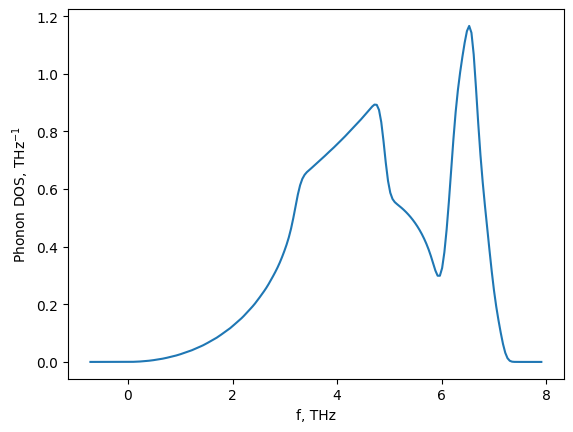

In [18]:
# calculate phonon
phonon_calculator = PhonopyCalculator(struc_opt)
phonon_calculator.calculate()
plt.plot(phonon_calculator.VALUE["dos_energies"], phonon_calculator.VALUE["dos_total"])
plt.xlabel("f, THz")
plt.ylabel("Phonon DOS, THz$^{-1}$")

In [19]:
# FCC high symmetry paths of the first Brillouin zone
path_fcc = [[[0, 0, 0], [0.5, 0, 0.5], [0.625, 0.25, 0.625],
        [0.375, 0.375, 0.75], [0, 0, 0], [0.5, 0.5, 0.5], [0.5, 0.25, 0.75]]]
labels_fcc = ["G", "X", "U", "K", "G", "L", "W"]

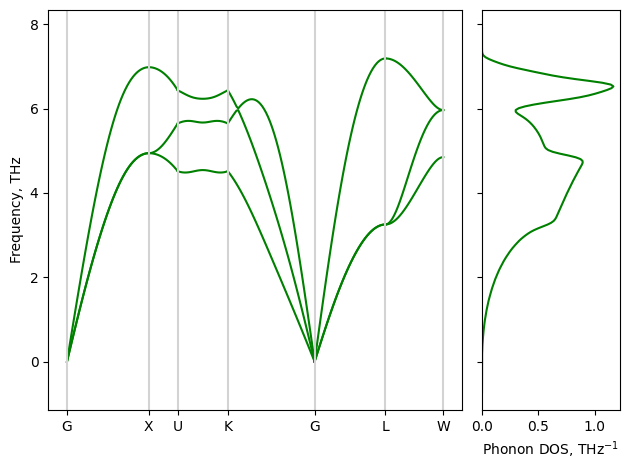

In [20]:
# phonon calculation of fcc structure
phonon_calculator.plot_band_structure_and_dos(path_fcc, labels_fcc, plot_kwargs={"color":"green"})
#plt.savefig("Frequency_fcc.png")

### E-V curves

In [21]:
# Choose structures for E-V plot (Murnaghan)
s_murn=["hcp","fcc","bcc","dhcp"]

# Sets the volume range
Veq = 12
delV = 2
volume_range=[Veq-delV,Veq+delV]

In [22]:
strucs_murn=get_structures_dictionary(elm, include=s_murn)
murn={}
for struc in strucs_murn:
    print(struc)
    at=strucs_murn[struc]['atoms']
    at.set_calculator(calc)
    murn[struc]={"vol":[],"ene":[],"pre":[]}   
    vr = np.array(volume_range)*len(at)
    murn_calculator = MurnaghanCalculator(at,num_of_point=21,volume_range=vr)
    murn_calculator.calculate()
    murn[struc]["vol"]=murn_calculator.VALUE["volume"]/len(at)
    murn[struc]["ene"]=murn_calculator.VALUE["energy"]/len(at)
    murn[struc]["pre"]=murn_calculator.VALUE["pressure"]*eV_per_A3_to_GPa
    murn[struc]["eqstruc"]=murn_calculator.get_final_structure()

fcc
bcc
hcp
dhcp


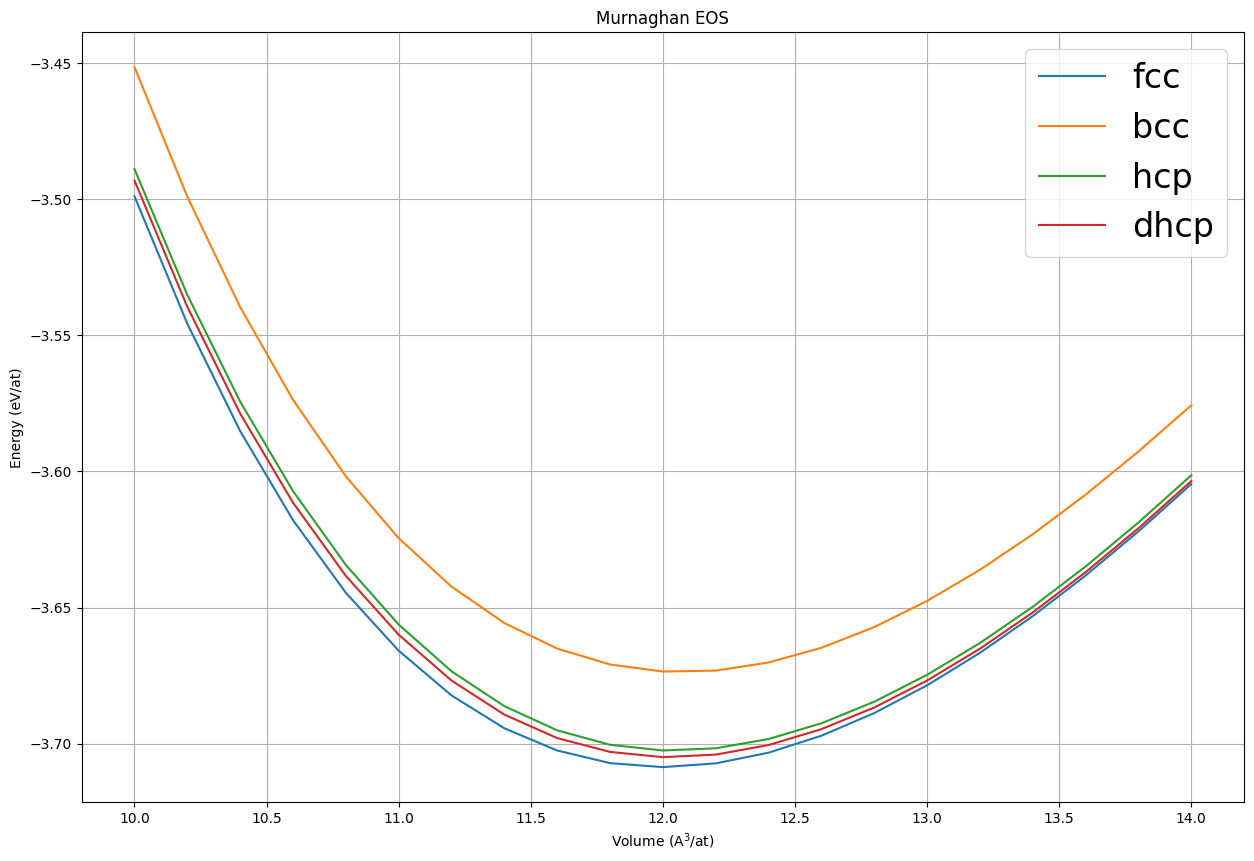

In [23]:
plt.figure(figsize=(15, 10))
plt.title("Murnaghan EOS")
for struc in strucs_murn:
    plt.plot(murn[struc]["vol"],murn[struc]["ene"],label=struc)
plt.xlabel("Volume (A$^3$/at)")
plt.ylabel("Energy (eV/at)");
#plt.ylim(en_opt-0.2,1)
plt.grid()
plt.legend(loc=0, prop={'size': 24})

### E-NNB curves

In [24]:
# Choose structures for E-NNB plot (broad range)
s_nnb=["dimer","hcp","fcc","bcc","sc"]

In [25]:
strucs_nnb=get_structures_dictionary(elm, include=s_nnb)
ev={}
for struc in strucs_nnb:
    print(struc)
    at=strucs_nnb[struc]['atoms']
    at.set_calculator(calc)

    ev[struc]={"nnb":[],"ene":[],"grad":[],"stress":[]}
    e_nn_calculator = NearestNeighboursExpansionCalculator(at, 
#                                                  num_of_point=50, 
                                                  nn_distance_range=(1,rcut),
                                                  nn_distance_step=0.05
                                                 )
    e_nn_calculator.calculate()
    ev[struc]["nnb"]=e_nn_calculator.VALUE["nn_distances"]
    ev[struc]["ene"]=e_nn_calculator.VALUE["energy"]/len(at)
    ev[struc]["stress"]=e_nn_calculator.VALUE["stresses"]*eV_per_A3_to_GPa
    ev[struc]["grad"]=e_nn_calculator.VALUE["gradient"]

fcc
bcc
hcp
sc
dimer


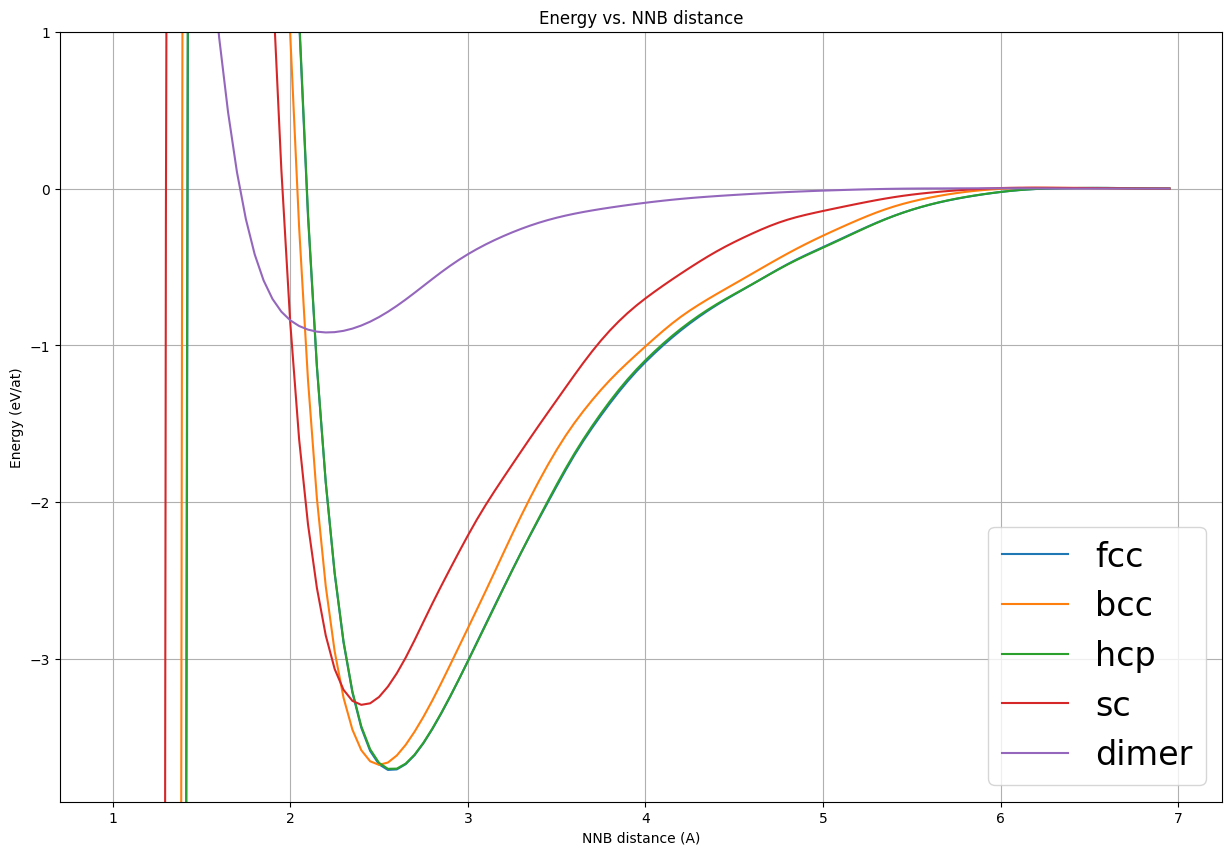

In [26]:
plt.figure(figsize=(15, 10))
plt.title("Energy vs. NNB distance")
for struc in strucs_nnb:
    plt.plot(ev[struc]["nnb"],ev[struc]["ene"],label=struc)
plt.xlabel("NNB distance (A)")
plt.ylabel("Energy (eV/at)");
plt.ylim(en_opt-0.2,1)
plt.grid()
plt.legend(loc=4, prop={'size': 24})
plt.savefig("energy_vs_nnb.png")

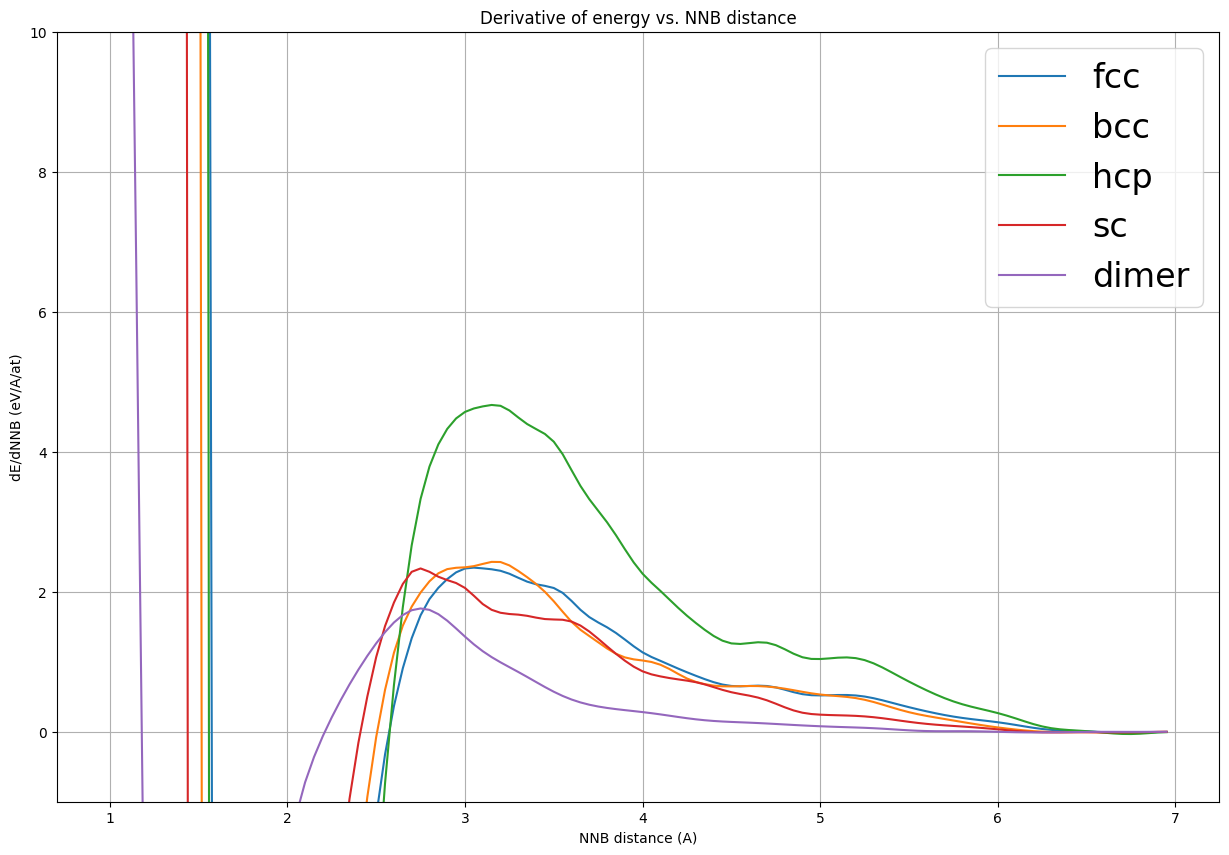

In [27]:
plt.figure(figsize=(15, 10))
plt.title("Derivative of energy vs. NNB distance")
for struc in strucs_nnb:
    plt.plot(ev[struc]["nnb"],ev[struc]["grad"],label=struc)
plt.xlabel("NNB distance (A)")
plt.ylabel("dE/dNNB (eV/A/at)");
plt.ylim(-1,10)
plt.grid()
plt.legend(loc=1, prop={'size': 24})
plt.savefig("dE_dNNB_vs_nnb.png")

### E-P curves

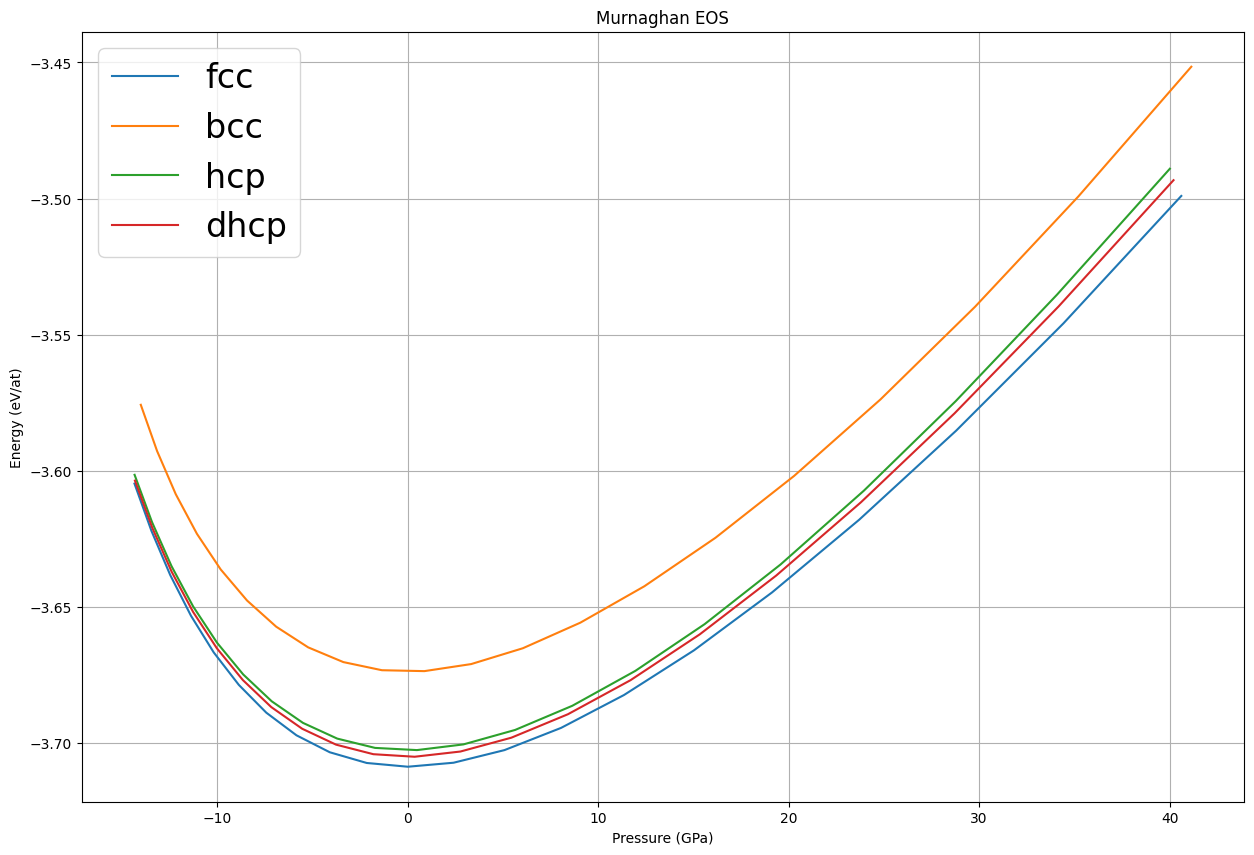

In [28]:
plt.figure(figsize=(15, 10))
plt.title("Murnaghan EOS")
for struc in strucs_murn:
    plt.plot(murn[struc]["pre"],murn[struc]["ene"],label=struc)
plt.xlabel("Pressure (GPa)")
plt.ylabel("Energy (eV/at)");
#plt.ylim(en_opt-0.2,1)
plt.grid()
plt.legend(loc=0, prop={'size': 24})
#plt.savefig("Energy_vs_Pressure.png")

### Configuration information

In [29]:
d = {}
for struc in strucs_murn:
    at=strucs_murn[struc]['atoms']
    stress_tmp=murn[struc]["eqstruc"].get_stress()*eV_per_A3_to_GPa*1000
    energy_tmp=murn[struc]["eqstruc"].get_potential_energy()/len(at)
    d1 = {struc:{'Latpars[A]': murn[struc]["eqstruc"].cell.lengths(), 'Principal stresses[MPa]': stress_tmp[0:3], 'Energy[eV]': energy_tmp}}
    d.update(d1)

In [30]:
dict2data = pd.DataFrame.from_dict(d, orient='index')
dict2data

,Latpars[A],Principal stresses[MPa],Energy[eV]
fcc,"[2.569804503316593, 2.569804503316593, 2.56980...","[4.991015180942491, 4.991015180941531, 4.99101...",-3.708604
bcc,"[2.503164963086453, 2.503164963086453, 2.50316...","[-17.93271027409763, -17.93271027409785, -17.9...",-3.673708
hcp,"[2.5728542991205376, 2.5728542991205376, 4.201...","[226.26311625280013, 226.26311625280093, -402....",-3.702559
dhcp,"[2.5720954720358638, 2.5720954720358638, 8.400...","[169.8443727188516, 169.84437271885184, -305.5...",-3.704976


### Transformation paths

In [31]:
# Get the bcc structure and rescale it to the volume of the equilibrium fcc
struc_tmp = get_structures_dictionary(elm, include="bcc")
struc_bcc = struc_tmp["bcc"]["atoms"]
v_fcc = struc_opt.get_volume()
v_bcc = struc_bcc.get_volume()

cell = struc_bcc.get_cell()
new_cell = (v_fcc/v_bcc)**(1.0/3.0)*cell
struc_bcc.set_cell(new_cell, scale_atoms=True)
struc_bcc.set_calculator(calc)

trans_path_trig  = TransformationPathCalculator(struc_bcc, transformation_type="trigonal",num_of_point=100)
trans_path_hex   = TransformationPathCalculator(struc_bcc, transformation_type="hexagonal",num_of_point=100)
trans_path_tetra = TransformationPathCalculator(struc_bcc, transformation_type="tetragonal",num_of_point=100)
trans_path_ortho = TransformationPathCalculator(struc_bcc, transformation_type="orthogonal",num_of_point=100)
trans_path_trig.calculate()
trans_path_hex.calculate()
trans_path_tetra.calculate()
trans_path_ortho.calculate()

/home/jiahaopan/.conda/envs/pace38_virtual/lib/python3.8/site-packages/ase-3.22.1-py3.8.egg/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)


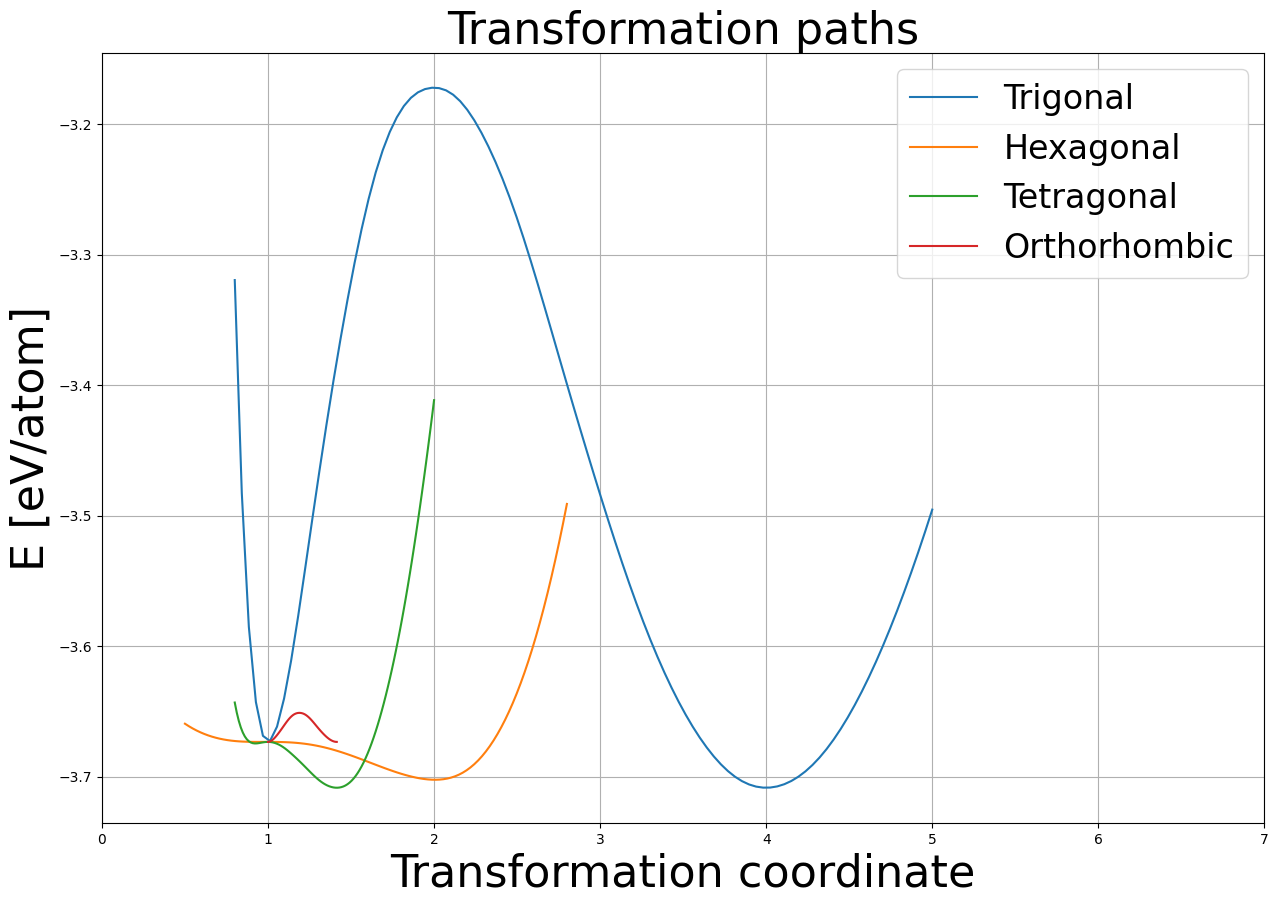

In [32]:
plt.figure(figsize=(15,10))
plt.plot(trans_path_trig.value['transformation_coordinates'],trans_path_trig.value['energies_0']/2.0,label="Trigonal")
plt.plot(trans_path_hex.value['transformation_coordinates']+1,trans_path_hex.value['energies_0']/4.0,label="Hexagonal")
plt.plot(trans_path_tetra.value['transformation_coordinates'],trans_path_tetra.value['energies_0']/2.0,label="Tetragonal")
plt.plot(trans_path_ortho.value['transformation_coordinates'],trans_path_ortho.value['energies_0']/4.0,label="Orthorhombic")

plt.title("Transformation paths", fontsize=32)
#plt.ylim(-4,-3)
plt.xlim(0,7)
plt.xlabel("Transformation coordinate", fontsize=32)
plt.ylabel("E [eV/atom]", fontsize=32)
plt.grid()
plt.legend(loc=0, prop={'size': 24})
plt.savefig("Energy_vs_Transformation_coordinate.png")

### Summary of basic properties - DFT comparison

In [33]:
# ACE Information
# lattice etc
opt_information = {"ACE": {"element": elm, "equil_structure": equilstruc, "No. of atoms": len(struc_opt), "Lattice": lattice_opt, "Dimensions": struc_opt.cell.lengths(), "Angles": struc_opt.cell.angles(), "Energy": en_opt/len(struc_opt), "Maximum force": fmax_opt, "Stress 11": np.array(stress_opt[0]), "Stress 22": np.array(stress_opt[1]), "Stress 33": np.array(stress_opt[2]), "Stress 12": np.array(stress_opt[5]), "Stress 13": np.array(stress_opt[4]), "Stress 23": np.array(stress_opt[3])}}
# elastic constant
opt_information['ACE']['C11'] = elmat.VALUE["C"][0,0]
opt_information['ACE']['C22'] = elmat.VALUE["C"][0,1]
opt_information['ACE']['C33'] = elmat.VALUE["C"][3,3]
# bulk mudule
opt_information['ACE']['B'] = elmat.VALUE["BV"]
# Vacancy
for i in vacancy_calculator.value['vacancy_formation_energy']:
    en_vac_ace=vacancy_calculator.value["vacancy_formation_energy"][i]
    opt_information['ACE']["%10s"%i] = en_vac_ace
# surface energy
opt_information['ACE']['Surface(100) energy (J/m2)'] = surface100
opt_information['ACE']['Surface(110) energy (J/m2)'] = surface110
opt_information['ACE']['Surface(111) energy (J/m2)'] = surface111

In [34]:
# DFT Information
# lattice etc
DFT_information = {"DFT": {"element": elm, "equil_structure": 'fcc', "No. of atoms": '1', "Lattice": '3.635', "Energy": '-3.7253', "Maximum force": '0'}}
# elastic constant
DFT_information['DFT']['C11'] = '178'
DFT_information['DFT']['C22'] = '123'
DFT_information['DFT']['C33'] = '75'
# bulk mudule
DFT_information['DFT']['B'] = '141'
# Vacancy
for i in vacancy_calculator.value['vacancy_formation_energy']:
    DFT_information['DFT']["%10s"%i] = '1.07'
# surface energy
DFT_information['DFT']['Surface(100) energy (J/m2)'] = '1.51'
DFT_information['DFT']['Surface(110) energy (J/m2)'] = '1.57'
DFT_information['DFT']['Surface(111) energy (J/m2)'] = '1.36'

In [35]:
opt_information.update(DFT_information)
dict_conclusion = pd.DataFrame.from_dict(opt_information)
dict_conclusion

,ACE,DFT
element,Cu,Cu
equil_structure,fcc,fcc
No. of atoms,1,1
Lattice,3.633707,3.635
Dimensions,"[2.5694186262441736, 2.5694186262441736, 2.569...",NaN
Angles,"[59.99999999999999, 60.00000000000001, 60.0000...",NaN
Energy,-3.708603,-3.7253
Maximum force,0,0
Stress 11,-0.05658631971471207,NaN
Stress 22,-0.05658631971471409,NaN


### Radar chart

In [36]:
# Determine whether it is a number or not
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        pass
 
    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass
 
    return False

In [37]:
# Set up the data
df = {'Relative error':{}}
for key, value in dict_conclusion['DFT'].items():
    if not pd.isnull(value) and is_number(value) and value != '0':
        df['Relative error'][key] = (float(dict_conclusion['ACE'][key])-float(dict_conclusion['DFT'][key]))/float(dict_conclusion['DFT'][key])*100
    else:
        pass

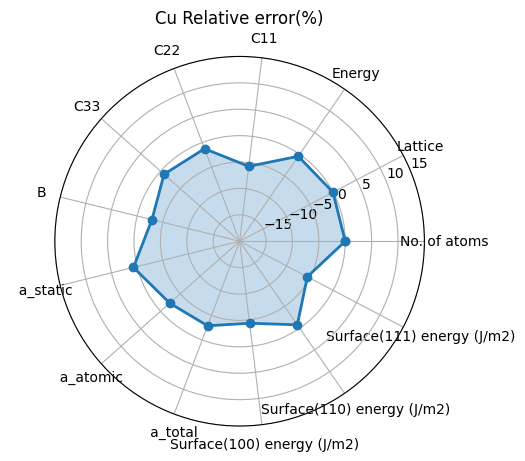

In [38]:
feature = list(df['Relative error'].keys())
values = list(df['Relative error'].values())
angles=np.linspace(0, 2*np.pi,len(feature), endpoint=False)
values=np.concatenate((values,[values[0]]))
angles=np.concatenate((angles,[angles[0]]))
# drawing
fig=plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, values, 'o-', linewidth=2)
ax.fill(angles, values, alpha=0.25)
  
# Set the range of the radar chart
ax.set_ylim(-20,15)
# Add a title
plt.title('Cu Relative error(%)')
# Add grid lines
ax.grid(True)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(feature)
plt.show()


# W

### Initial setup

In [39]:
# Element name and the expected equilibrium crystal structure
elm = "W"
equilstruc = "bcc"

### Lattice constant calculation

In [40]:
# Use ams_tools dictionary of structures
struc_tmp=get_structures_dictionary(elm, include=equilstruc)
struc_ini = struc_tmp[equilstruc]["atoms"]
# Optimize the initial structure
struc_ini.set_calculator(calc)
optimizer=SpecialOptimizer(struc_ini)
struc_opt = optimizer.run()
struc_opt.set_calculator(calc)
en_opt=struc_opt.get_potential_energy()/len(struc_opt)
stress_opt=struc_opt.get_stress()*eV_per_A3_to_GPa
f_opt=struc_opt.get_forces()
fmax_opt = 0
E_refer_W = en_opt
for i in f_opt:
    fval = (float(i[0])**2 + float(i[1])**2 + float(i[2])**2)**(1./2.)
    if fval > fmax_opt:
        fmax_opt = fval
lattice_opt = (struc_opt.cell.lengths()[0])*2/(3**(1/2))
#opt_information = {"opt_structure": {"element": elm, "equil_structure": equilstruc, "No. of atoms": len(struc_opt), "Lattice": lattice_opt, "Dimensions": struc_opt.cell.lengths(), "Angles": struc_opt.cell.angles(), "Energy": en_opt/len(struc_opt), "Maximum force": fmax_opt, "Stress 11": np.array(stress_opt[0]), "Stress 22": np.array(stress_opt[1]), "Stress 33": np.array(stress_opt[2]), "Stress 12": np.array(stress_opt[5]), "Stress 13": np.array(stress_opt[4]), "Stress 23": np.array(stress_opt[3])}}

/home/jiahaopan/.conda/envs/pace38_virtual/lib/python3.8/site-packages/ase-3.22.1-py3.8.egg/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)


In [41]:
print("Lattice paramater : %6.4f A"% (lattice_opt))

Lattice paramater : 3.1862 A


### Surface energy calculation

In [42]:
# Create a surface model
slab100 = bcc100(elm, size=(4,4,10), a = lattice_opt, vacuum = 10.0)
slab110 = bcc110(elm, size=(4,4,10), a = lattice_opt, vacuum = 10.0)
slab111 = bcc111(elm, size=(4,4,10), a = lattice_opt, vacuum = 10.0)

In [43]:
# Modify the periodic boundary conditions
slab100.pbc = [True, True, True]
slab110.pbc = [True, True, True]
slab111.pbc = [True, True, True]

In [44]:
slab100.set_calculator(calc)
slab110.set_calculator(calc)
slab111.set_calculator(calc)
en_slab100=slab100.get_potential_energy()
en_slab110=slab110.get_potential_energy()
en_slab111=slab111.get_potential_energy()

In [45]:
surface100=(en_slab100-(en_opt)/len(struc_opt)*len(slab100))/(slab100.cell[0][0]*slab100.cell[1][1]-slab100.cell[0][1]*slab100.cell[1][0])*eV_to_J/A_to_m/A_to_m/2
surface110=(en_slab110-(en_opt)/len(struc_opt)*len(slab110))/(slab110.cell[0][0]*slab110.cell[1][1]-slab110.cell[0][1]*slab110.cell[1][0])*eV_to_J/A_to_m/A_to_m/2
surface111=(en_slab111-(en_opt)/len(struc_opt)*len(slab111))/(slab111.cell[0][0]*slab111.cell[1][1]-slab111.cell[0][1]*slab111.cell[1][0])*eV_to_J/A_to_m/A_to_m/2

In [46]:
print("Surface(100) energy  : %6.4f J/m2"% (surface100))
print("Surface(110) energy  : %6.4f J/m2"% (surface110))
print("Surface(111) energy  : %6.4f J/m2"% (surface111))

Surface(100) energy  : 4.0317 J/m2
Surface(110) energy  : 3.4452 J/m2
Surface(111) energy  : 3.9830 J/m2


### Elastic constant calculation

In [47]:
# calculate the elastic matrix
elmat = ElasticMatrixCalculator(struc_opt)
elmat.calculate()

In [48]:
# print elastic constants and judge the stability of this structure 
print("\n-----------------------------------------")
print("Elastic constants")
print("C11 = %4.0f GPa"% elmat.VALUE["C"][0,0])
print("C12 = %4.0f GPa"% elmat.VALUE["C"][0,1])
print("C44 = %4.0f GPa"% elmat.VALUE["C"][3,3])
print("BV  = %4.0f GPa"% elmat.VALUE["BV"])

print("\nCauchy pressure")
print("C12-C44 = %4.0f GPa"% (elmat.VALUE["C"][0,1]-elmat.VALUE["C"][3,3]))

print("\nBorn stability criteria for cubic crystals")
print("C11-C12 >0 : %4.0f GPa"% (elmat.VALUE["C"][0,0]-elmat.VALUE["C"][0,1]))
print("C11+2C12>0 : %4.0f GPa"% (elmat.VALUE["C"][0,0]+2*elmat.VALUE["C"][0,1]))
print("C44>0      : %4.0f GPa"% elmat.VALUE["C"][3,3])
print("-----------------------------------------")


-----------------------------------------
Elastic constants
C11 =  519 GPa
C12 =  225 GPa
C44 =  155 GPa
BV  =  323 GPa

Cauchy pressure
C12-C44 =   70 GPa

Born stability criteria for cubic crystals
C11-C12 >0 :  294 GPa
C11+2C12>0 :  968 GPa
C44>0      :  155 GPa
-----------------------------------------


### Vacancy formation energy calculation

In [49]:
# calculate the vacancy formation energy
vacancy_calculator = DefectFormationCalculator(struc_opt)
vacancy_calculator.calculate()

ase.spacegroup.symmetrize: prec 0.01 got symmetry group number 229 , international (Hermann-Mauguin) Im-3m , Hall  -I 4 2 3
ase.spacegroup.symmetrize: prec 0.01 got symmetry group number 229 , international (Hermann-Mauguin) Im-3m , Hall  -I 4 2 3
ase.spacegroup.symmetrize: prec 0.0001 got symmetry group number 229 , international (Hermann-Mauguin) Im-3m , Hall  -I 4 2 3
ase.spacegroup.symmetrize: prec 0.01 got symmetry group number 229 , international (Hermann-Mauguin) Im-3m , Hall  -I 4 2 3
ase.spacegroup.symmetrize: prec 0.01 got symmetry group number 229 , international (Hermann-Mauguin) Im-3m , Hall  -I 4 2 3
ase.spacegroup.symmetrize: prec 0.01 got symmetry group number 229 , international (Hermann-Mauguin) Im-3m , Hall  -I 4 2 3
ase.spacegroup.symmetrize: prec 0.0001 got symmetry group number 229 , international (Hermann-Mauguin) Im-3m , Hall  -I 4 2 3
ase.spacegroup.symmetrize: prec 0.01 got symmetry group number 229 , international (Hermann-Mauguin) Im-3m , Hall  -I 4 2 3
! BA

In [50]:
# print vacancy formation energy
print("-----------------------------------------")
print("Vacancy formation energies")
for i in vacancy_calculator.value['vacancy_formation_energy']:
    en_vac_ace=vacancy_calculator.value["vacancy_formation_energy"][i]
    print("Site/type: %10s"%i," :: Energy: %6.3f eV"% en_vac_ace)
print("-----------------------------------------")

-----------------------------------------
Vacancy formation energies
Site/type:   a_static  :: Energy:  3.468 eV
Site/type:   a_atomic  :: Energy:  3.389 eV
Site/type:    a_total  :: Energy:  3.346 eV
-----------------------------------------


### Phonon spectrum

Text(0, 0.5, 'Phonon DOS, THz$^{-1}$')

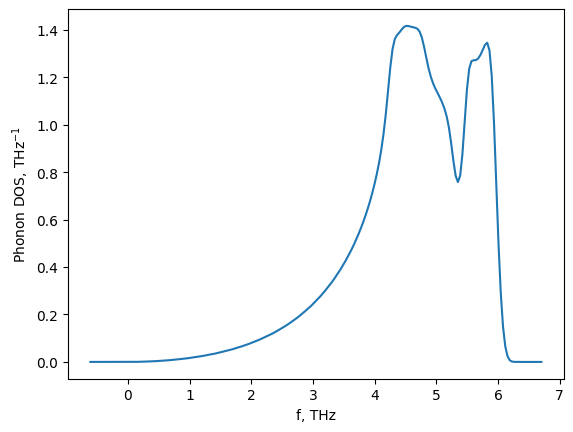

In [51]:
# calculate phonon
phonon_calculator = PhonopyCalculator(struc_opt)
phonon_calculator.calculate()
plt.plot(phonon_calculator.VALUE["dos_energies"], phonon_calculator.VALUE["dos_total"])
plt.xlabel("f, THz")
plt.ylabel("Phonon DOS, THz$^{-1}$")

In [52]:
# BCC high symmetry paths of the first Brillouin zone
path_bcc = [[[0, 0, 0], [0.5, -0.5, 0.5], [0.25, 0.25, 0.25], [0, 0, 0], [0, 0, 0.5]]]
labels_bcc = ["G", "H", "P", "G", "N"]

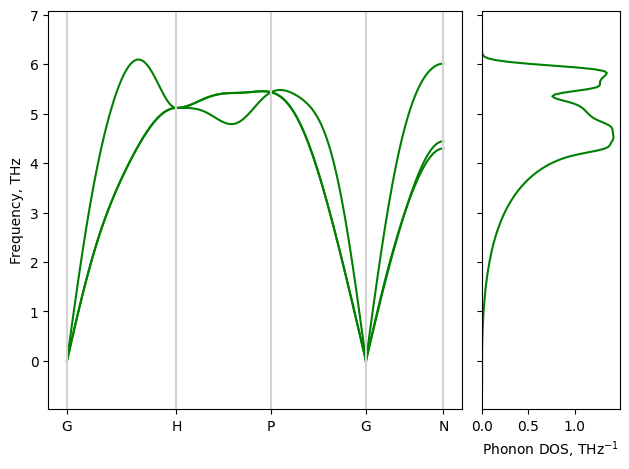

In [53]:
# phonon calculation of bcc structure
phonon_calculator.plot_band_structure_and_dos(path_bcc, labels_bcc, plot_kwargs={"color":"green"})
#plt.savefig("Frequency_fcc.png")

### E-V curves

In [54]:
# Choose structures for E-V plot (Murnaghan)
s_murn=["hcp","fcc","bcc","dhcp"]

# Sets the volume range
Veq = 16
delV = 2
volume_range=[Veq-delV,Veq+delV]

In [55]:
strucs_murn=get_structures_dictionary(elm, include=s_murn)
murn={}
for struc in strucs_murn:
    print(struc)
    at=strucs_murn[struc]['atoms']
    at.set_calculator(calc)
    murn[struc]={"vol":[],"ene":[],"pre":[]}   
    vr = np.array(volume_range)*len(at)
    murn_calculator = MurnaghanCalculator(at,num_of_point=21,volume_range=vr)
    murn_calculator.calculate()
    murn[struc]["vol"]=murn_calculator.VALUE["volume"]/len(at)
    murn[struc]["ene"]=murn_calculator.VALUE["energy"]/len(at)
    murn[struc]["pre"]=murn_calculator.VALUE["pressure"]*eV_per_A3_to_GPa
    murn[struc]["eqstruc"]=murn_calculator.get_final_structure()

fcc
bcc
hcp
dhcp


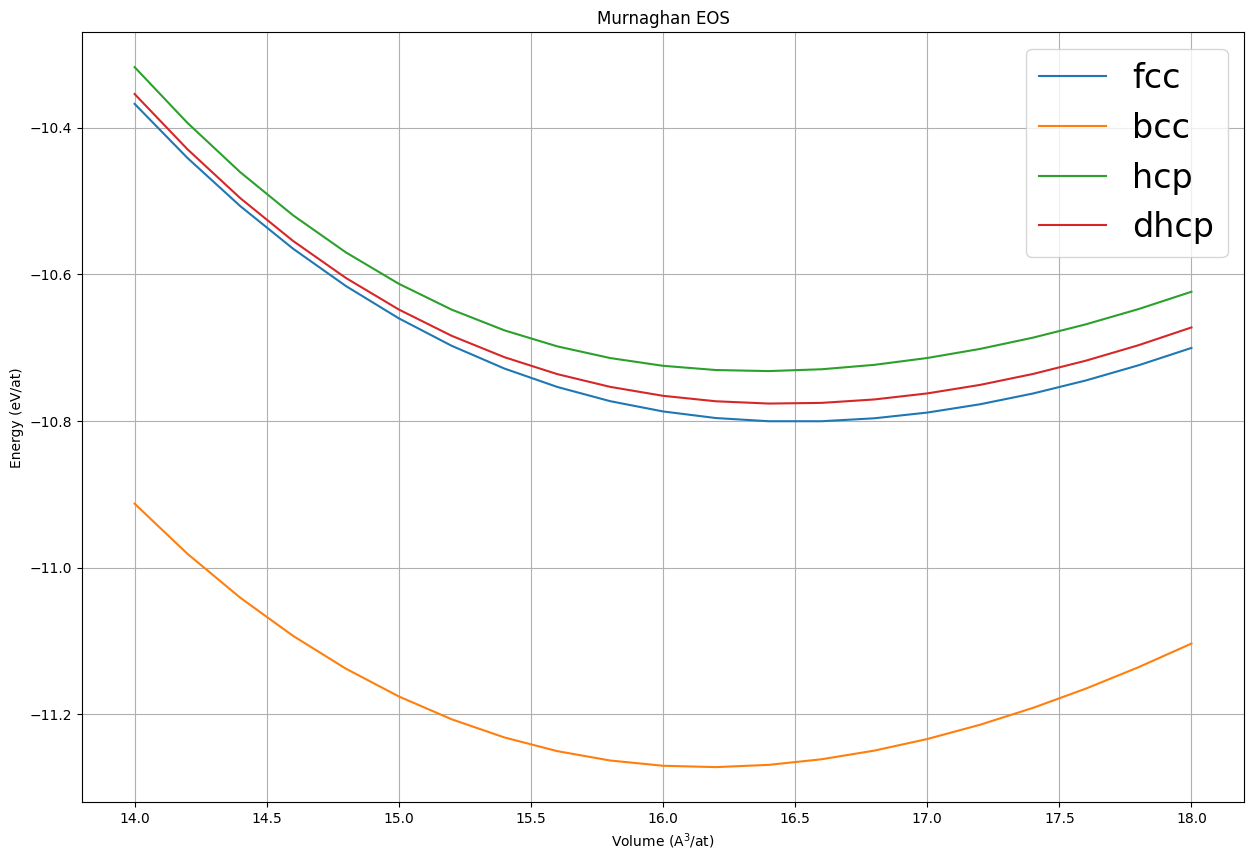

In [56]:
plt.figure(figsize=(15, 10))
plt.title("Murnaghan EOS")
for struc in strucs_murn:
    plt.plot(murn[struc]["vol"],murn[struc]["ene"],label=struc)
plt.xlabel("Volume (A$^3$/at)")
plt.ylabel("Energy (eV/at)");
#plt.ylim(en_opt-0.2,1)
plt.grid()
plt.legend(loc=0, prop={'size': 24})

### E-NNB curves

In [57]:
# Choose structures for E-NNB plot (broad range)
s_nnb=["dimer","hcp","fcc","bcc","sc"]

In [58]:
strucs_nnb=get_structures_dictionary(elm, include=s_nnb)
ev={}
for struc in strucs_nnb:
    print(struc)
    at=strucs_nnb[struc]['atoms']
    at.set_calculator(calc)

    ev[struc]={"nnb":[],"ene":[],"grad":[],"stress":[]}
    e_nn_calculator = NearestNeighboursExpansionCalculator(at, 
#                                                  num_of_point=50, 
                                                  nn_distance_range=(1,rcut),
                                                  nn_distance_step=0.05
                                                 )
    e_nn_calculator.calculate()
    ev[struc]["nnb"]=e_nn_calculator.VALUE["nn_distances"]
    ev[struc]["ene"]=e_nn_calculator.VALUE["energy"]/len(at)
    ev[struc]["stress"]=e_nn_calculator.VALUE["stresses"]*eV_per_A3_to_GPa
    ev[struc]["grad"]=e_nn_calculator.VALUE["gradient"]

fcc
bcc
hcp
sc
dimer


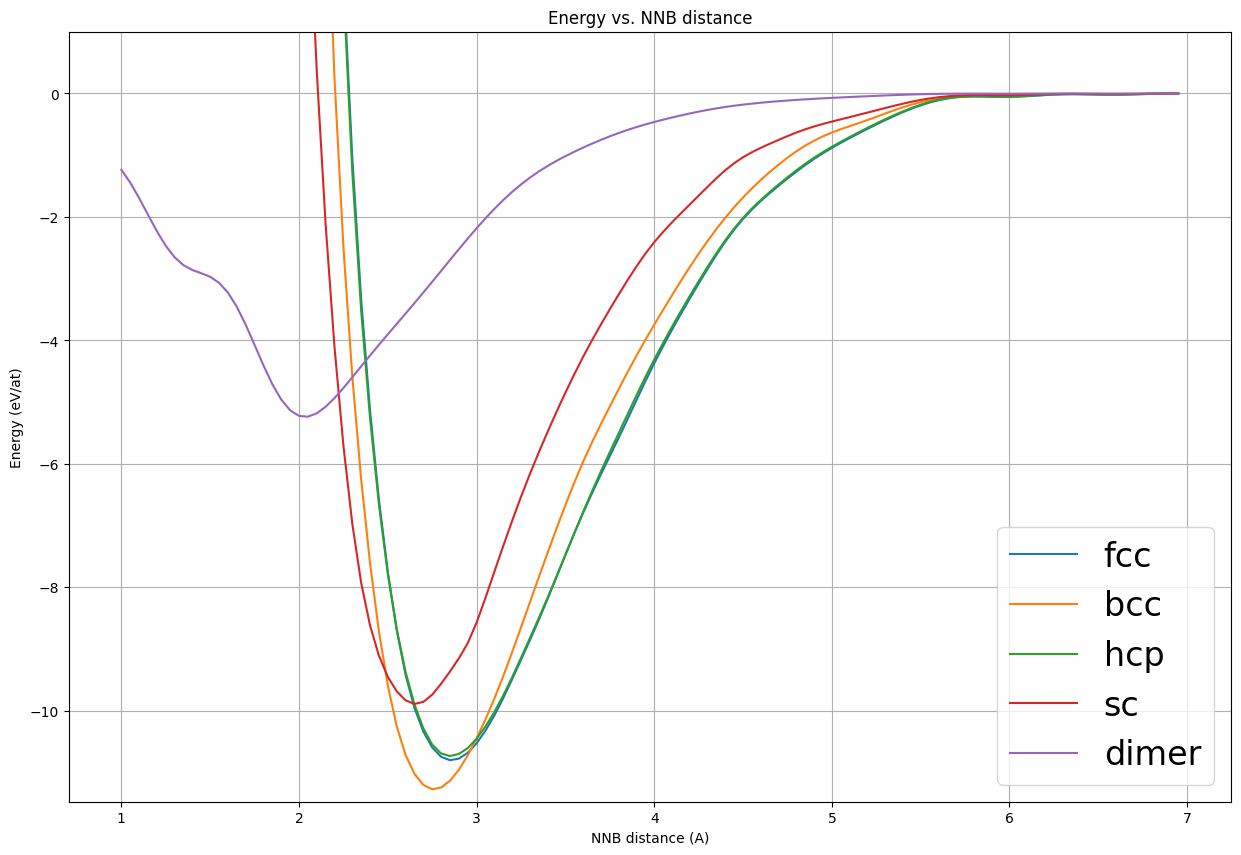

In [59]:
plt.figure(figsize=(15, 10))
plt.title("Energy vs. NNB distance")
for struc in strucs_nnb:
    plt.plot(ev[struc]["nnb"],ev[struc]["ene"],label=struc)
plt.xlabel("NNB distance (A)")
plt.ylabel("Energy (eV/at)");
plt.ylim(en_opt-0.2,1)
plt.grid()
plt.legend(loc=4, prop={'size': 24})
plt.savefig("energy_vs_nnb.png")

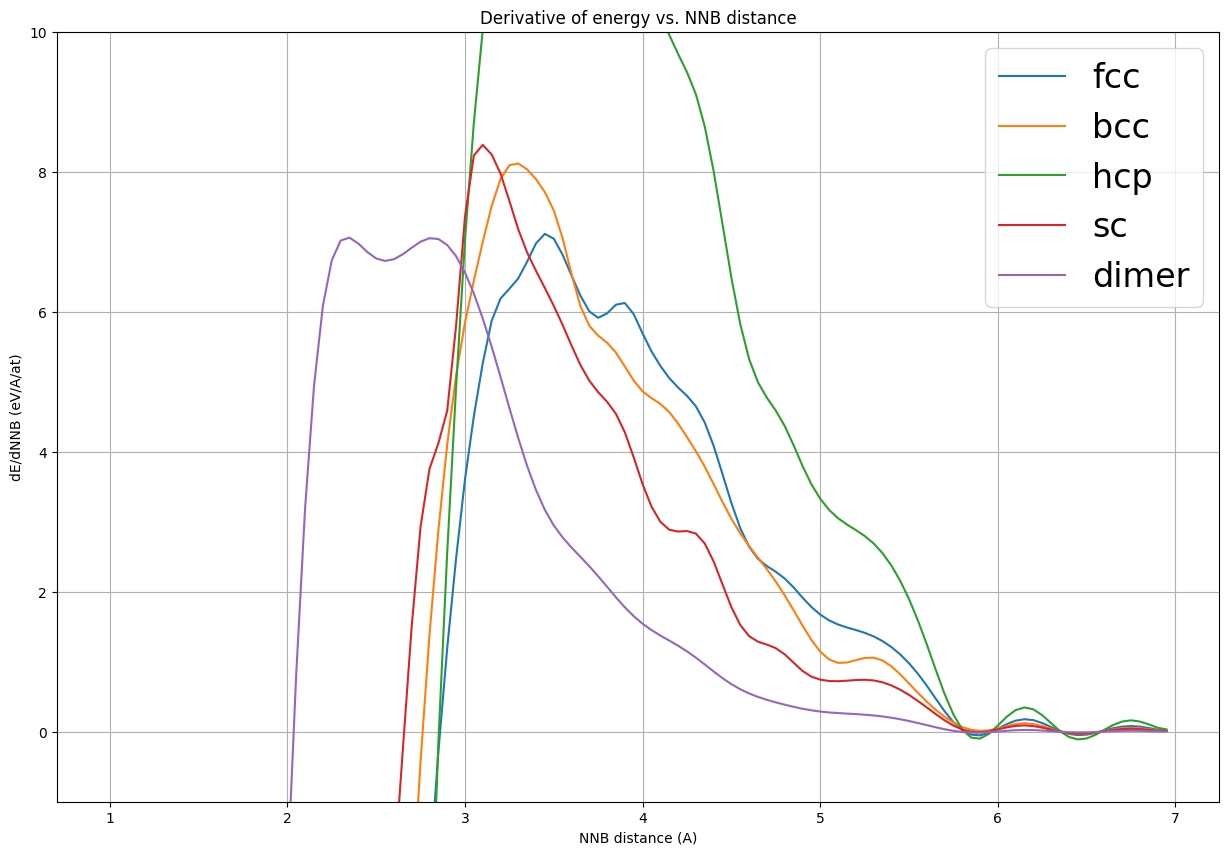

In [60]:
plt.figure(figsize=(15, 10))
plt.title("Derivative of energy vs. NNB distance")
for struc in strucs_nnb:
    plt.plot(ev[struc]["nnb"],ev[struc]["grad"],label=struc)
plt.xlabel("NNB distance (A)")
plt.ylabel("dE/dNNB (eV/A/at)");
plt.ylim(-1,10)
plt.grid()
plt.legend(loc=1, prop={'size': 24})
plt.savefig("dE_dNNB_vs_nnb.png")

### E-P curves

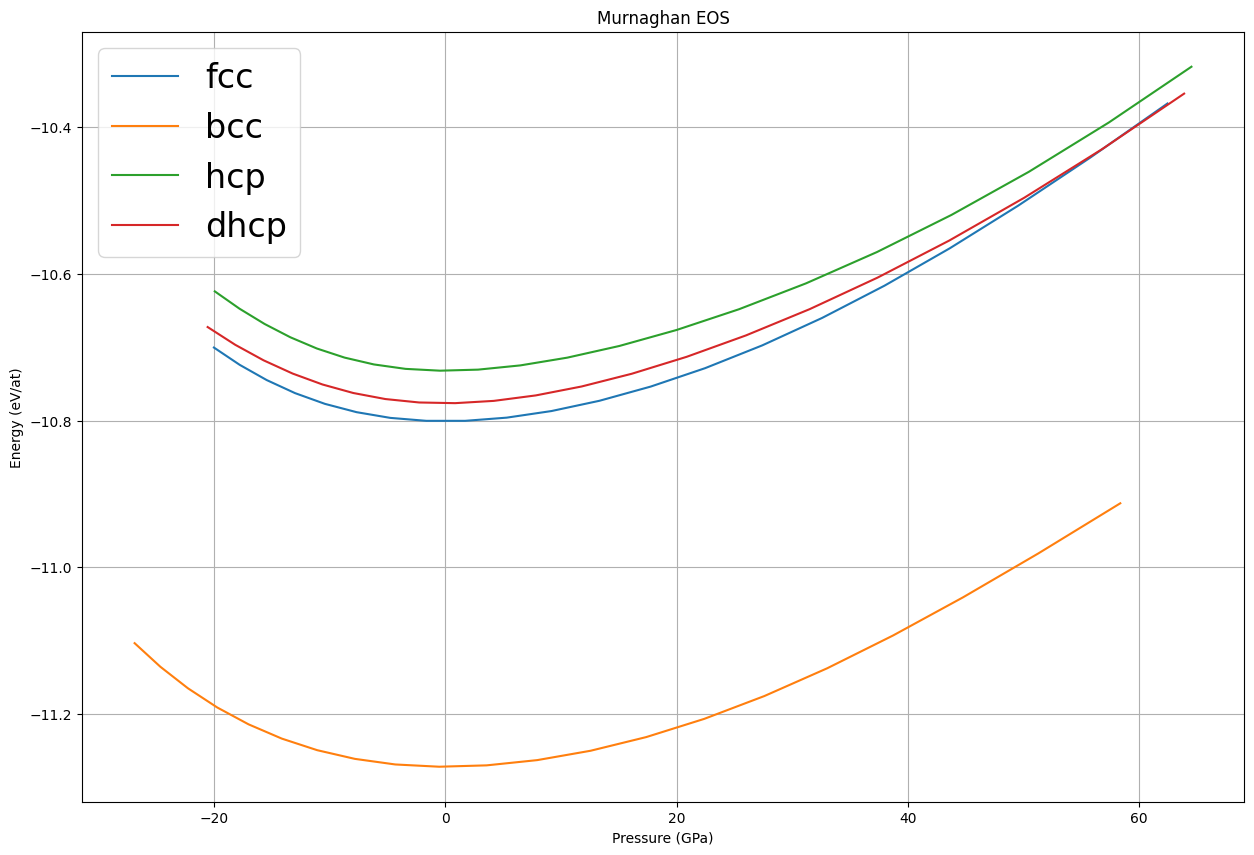

In [61]:
plt.figure(figsize=(15, 10))
plt.title("Murnaghan EOS")
for struc in strucs_murn:
    plt.plot(murn[struc]["pre"],murn[struc]["ene"],label=struc)
plt.xlabel("Pressure (GPa)")
plt.ylabel("Energy (eV/at)");
#plt.ylim(en_opt-0.2,1)
plt.grid()
plt.legend(loc=0, prop={'size': 24})
#plt.savefig("Energy_vs_Pressure.png")

### Configuration information

In [62]:
d = {}
for struc in strucs_murn:
    at=strucs_murn[struc]['atoms']
    stress_tmp=murn[struc]["eqstruc"].get_stress()*eV_per_A3_to_GPa*1000
    energy_tmp=murn[struc]["eqstruc"].get_potential_energy()/len(at)
    print(murn[struc]["eqstruc"].cell.lengths())
    d1 = {struc:{'Latpars[A]': murn[struc]["eqstruc"].cell.lengths(), 'Principal stresses[MPa]': stress_tmp[0:3], 'Energy[eV]': energy_tmp}}
    d.update(d1)

[2.85761187 2.85761187 2.85761187]
[2.7596318 2.7596318 2.7596318]
[2.84986205 2.84986205 4.65380524]
[2.85457554 2.85457554 9.32300467]


In [63]:
dict2data = pd.DataFrame.from_dict(d, orient='index')
dict2data

,Latpars[A],Principal stresses[MPa],Energy[eV]
fcc,"[2.857611874882508, 2.857611874882508, 2.85761...","[10.241713149287873, 10.241713149277095, 10.24...",-10.800785
bcc,"[2.7596318044043397, 2.7596318044043397, 2.759...","[107.9894435510564, 107.98944355104268, 107.98...",-11.272001
hcp,"[2.8498620473983456, 2.8498620473983456, 4.653...","[2529.127367387532, 2529.1273673873893, -5243....",-10.731913
dhcp,"[2.8545755373621944, 2.8545755373621944, 9.323...","[1164.6191339782793, 1164.6191339783088, -2545...",-10.776288


### Transformation paths

In [64]:
# Get the bcc structure and rescale it to the volume of the equilibrium fcc
struc_tmp = get_structures_dictionary(elm, include="bcc")
struc_bcc = struc_tmp["bcc"]["atoms"]
v_fcc = struc_opt.get_volume()
v_bcc = struc_bcc.get_volume()

cell = struc_bcc.get_cell()
new_cell = (v_fcc/v_bcc)**(1.0/3.0)*cell
struc_bcc.set_cell(new_cell, scale_atoms=True)
struc_bcc.set_calculator(calc)

trans_path_trig  = TransformationPathCalculator(struc_bcc, transformation_type="trigonal",num_of_point=100)
trans_path_hex   = TransformationPathCalculator(struc_bcc, transformation_type="hexagonal",num_of_point=100)
trans_path_tetra = TransformationPathCalculator(struc_bcc, transformation_type="tetragonal",num_of_point=100)
trans_path_ortho = TransformationPathCalculator(struc_bcc, transformation_type="orthogonal",num_of_point=100)
trans_path_trig.calculate()
trans_path_hex.calculate()
trans_path_tetra.calculate()
trans_path_ortho.calculate()

/home/jiahaopan/.conda/envs/pace38_virtual/lib/python3.8/site-packages/ase-3.22.1-py3.8.egg/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)


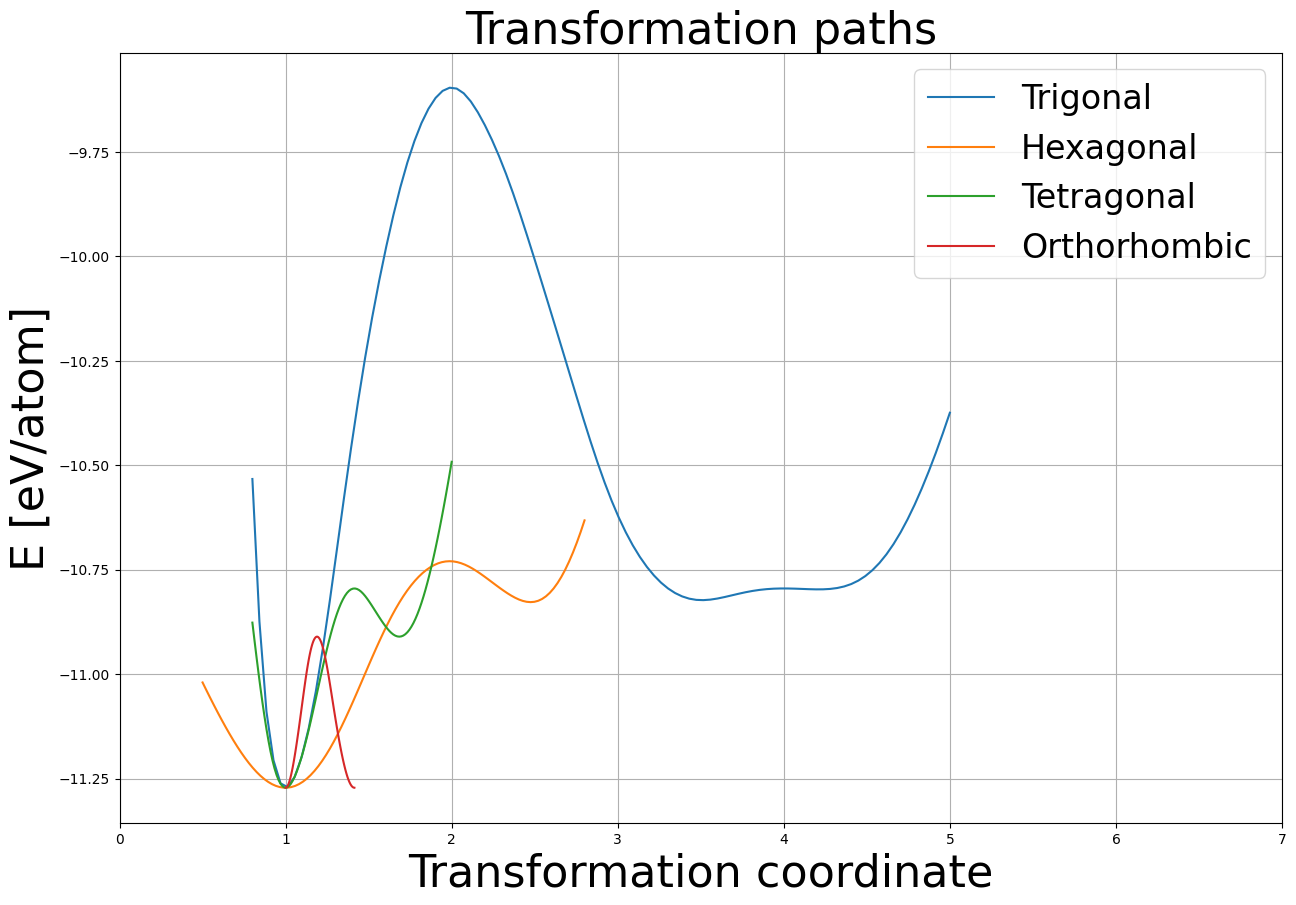

In [65]:
plt.figure(figsize=(15,10))
plt.plot(trans_path_trig.value['transformation_coordinates'],trans_path_trig.value['energies_0']/2.0,label="Trigonal")
plt.plot(trans_path_hex.value['transformation_coordinates']+1,trans_path_hex.value['energies_0']/4.0,label="Hexagonal")
plt.plot(trans_path_tetra.value['transformation_coordinates'],trans_path_tetra.value['energies_0']/2.0,label="Tetragonal")
plt.plot(trans_path_ortho.value['transformation_coordinates'],trans_path_ortho.value['energies_0']/4.0,label="Orthorhombic")

plt.title("Transformation paths", fontsize=32)
#plt.ylim(-4,-3)
plt.xlim(0,7)
plt.xlabel("Transformation coordinate", fontsize=32)
plt.ylabel("E [eV/atom]", fontsize=32)
plt.grid()
plt.legend(loc=0, prop={'size': 24})
plt.savefig("Energy_vs_Transformation_coordinate.png")

### Summary of basic properties - DFT comparison

In [66]:
# ACE Information
# lattice etc
opt_information = {"ACE": {"element": elm, "equil_structure": equilstruc, "No. of atoms": len(struc_opt), "Lattice": lattice_opt, "Dimensions": struc_opt.cell.lengths(), "Angles": struc_opt.cell.angles(), "Energy": en_opt/len(struc_opt), "Maximum force": fmax_opt, "Stress 11": np.array(stress_opt[0]), "Stress 22": np.array(stress_opt[1]), "Stress 33": np.array(stress_opt[2]), "Stress 12": np.array(stress_opt[5]), "Stress 13": np.array(stress_opt[4]), "Stress 23": np.array(stress_opt[3])}}
# elastic constant
opt_information['ACE']['C11'] = elmat.VALUE["C"][0,0]
opt_information['ACE']['C22'] = elmat.VALUE["C"][0,1]
opt_information['ACE']['C33'] = elmat.VALUE["C"][3,3]
# bulk mudule
opt_information['ACE']['B'] = elmat.VALUE["BV"]
# Vacancy
for i in vacancy_calculator.value['vacancy_formation_energy']:
    en_vac_ace=vacancy_calculator.value["vacancy_formation_energy"][i]
    opt_information['ACE']["%10s"%i] = en_vac_ace
# surface energy
opt_information['ACE']['Surface(100) energy (J/m2)'] = surface100
opt_information['ACE']['Surface(110) energy (J/m2)'] = surface110
opt_information['ACE']['Surface(111) energy (J/m2)'] = surface111

In [67]:
# DFT Information
# lattice etc
DFT_information = {"DFT": {"element": elm, "equil_structure": 'bcc', "No. of atoms": '1', "Lattice": '3.187', "Energy": '-11.252', "Maximum force": '0'}}
# elastic constant
DFT_information['DFT']['C11'] = '517'
DFT_information['DFT']['C22'] = '198'
DFT_information['DFT']['C33'] = '142'
# bulk mudule
DFT_information['DFT']['B'] = '304'
# Vacancy
for i in vacancy_calculator.value['vacancy_formation_energy']:
    DFT_information['DFT']["%10s"%i] = '3.27'
# surface energy
DFT_information['DFT']['Surface(100) energy (J/m2)'] = '4.02'
DFT_information['DFT']['Surface(110) energy (J/m2)'] = '3.27'
DFT_information['DFT']['Surface(111) energy (J/m2)'] = '3.56'

In [68]:
opt_information.update(DFT_information)
dict_conclusion = pd.DataFrame.from_dict(opt_information)
dict_conclusion

,ACE,DFT
element,W,W
equil_structure,bcc,bcc
No. of atoms,1,1
Lattice,3.186184,3.187
Dimensions,"[2.7593165350648396, 2.7593165350648396, 2.759...",NaN
Angles,"[109.47122063449069, 109.47122063449069, 109.4...",NaN
Energy,-11.272003,-11.252
Maximum force,0,0
Stress 11,-0.002630565672503409,NaN
Stress 22,-0.0026305656724832675,NaN


### Radar chart

In [69]:
# Determine whether it is a number or not
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        pass
 
    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass
 
    return False

In [70]:
#Set up the data
df = {'Relative error':{}}
for key, value in dict_conclusion['DFT'].items():
    if not pd.isnull(value) and is_number(value) and value != '0':
        df['Relative error'][key] = (float(dict_conclusion['ACE'][key])-float(dict_conclusion['DFT'][key]))/float(dict_conclusion['DFT'][key])*100
    else:
        pass

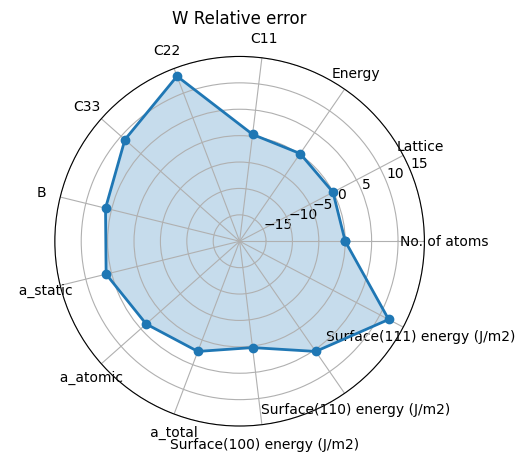

In [71]:
feature = list(df['Relative error'].keys())
values = list(df['Relative error'].values())
angles=np.linspace(0, 2*np.pi,len(feature), endpoint=False)
values=np.concatenate((values,[values[0]]))
angles=np.concatenate((angles,[angles[0]]))
# drawing
fig=plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, values, 'o-', linewidth=2)
ax.fill(angles, values, alpha=0.25)
  
# Set the range of the radar chart
ax.set_ylim(-20,15)
# Add a title
plt.title('W Relative error')
# Add grid lines
ax.grid(True)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(feature)
plt.show()


## CuW

In [72]:
# FCC modeling
L = 4
Cu3W = Atoms('WCu3', positions=[[0, 0, 0], [L/2, 0, L/2], [L/2, L/2, 0], [0, L/2, L/2]], cell=[L, L, L], pbc=[1, 1, 1])
CuW3 = Atoms('CuW3', positions=[[0, 0, 0], [L/2, 0, L/2], [L/2, L/2, 0], [0, L/2, L/2]], cell=[L, L, L], pbc=[1, 1, 1])
# BCC modeling
CuW = Atoms('CuW', positions=[[0, 0, 0], [L/2, L/2, L/2]], cell=[L, L, L], pbc=[1, 1, 1])

In [73]:
Cu3W.set_calculator(calc)
CuW.set_calculator(calc)
CuW3.set_calculator(calc)
murn1={}
murn1['Cu3W'] = Cu3W
murn1['CuW'] = CuW
murn1['CuW3'] = CuW3

In [74]:
murn = {}
delV = 8
Veq = 16
volume_range=[Veq-delV,Veq+delV]
for struc, struc_value in murn1.items(): 
    print(struc)
    vr = np.array(volume_range)*len(struc_value)
    Cu_count = struc_value.get_chemical_symbols().count('Cu')
    W_count = struc_value.get_chemical_symbols().count('W')
    murn[struc]={"vol":[],"ene":[],"pre":[]}
    murn_calculator = MurnaghanCalculator(struc_value, num_of_point=50, volume_range=vr)
    
    murn_calculator.calculate()
    murn[struc]["vol"]=murn_calculator.VALUE["volume"]/len(struc_value)
    murn[struc]["ene"]=(murn_calculator.VALUE["energy"]-Cu_count*E_refer_Cu-W_count*E_refer_W)/len(struc_value)
    murn[struc]["pre"]=murn_calculator.VALUE["pressure"]*eV_per_A3_to_GPa
    murn[struc]["eqstruc"]=murn_calculator.get_final_structure()
    # print(struc_value.get_chemical_symbols())
    # print(murn[struc]["ene"])
    # print(murn_calculator.VALUE["energy"])
    # print(Cu_count)
    # print(E_refer_Cu)
    # print(Cu_count*E_refer_Cu)

    

Cu3W


/home/jiahaopan/.conda/envs/pace38_virtual/lib/python3.8/site-packages/ase-3.22.1-py3.8.egg/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)


CuW
CuW3


Equilibrum lattice parameters and stresses of optimized structures


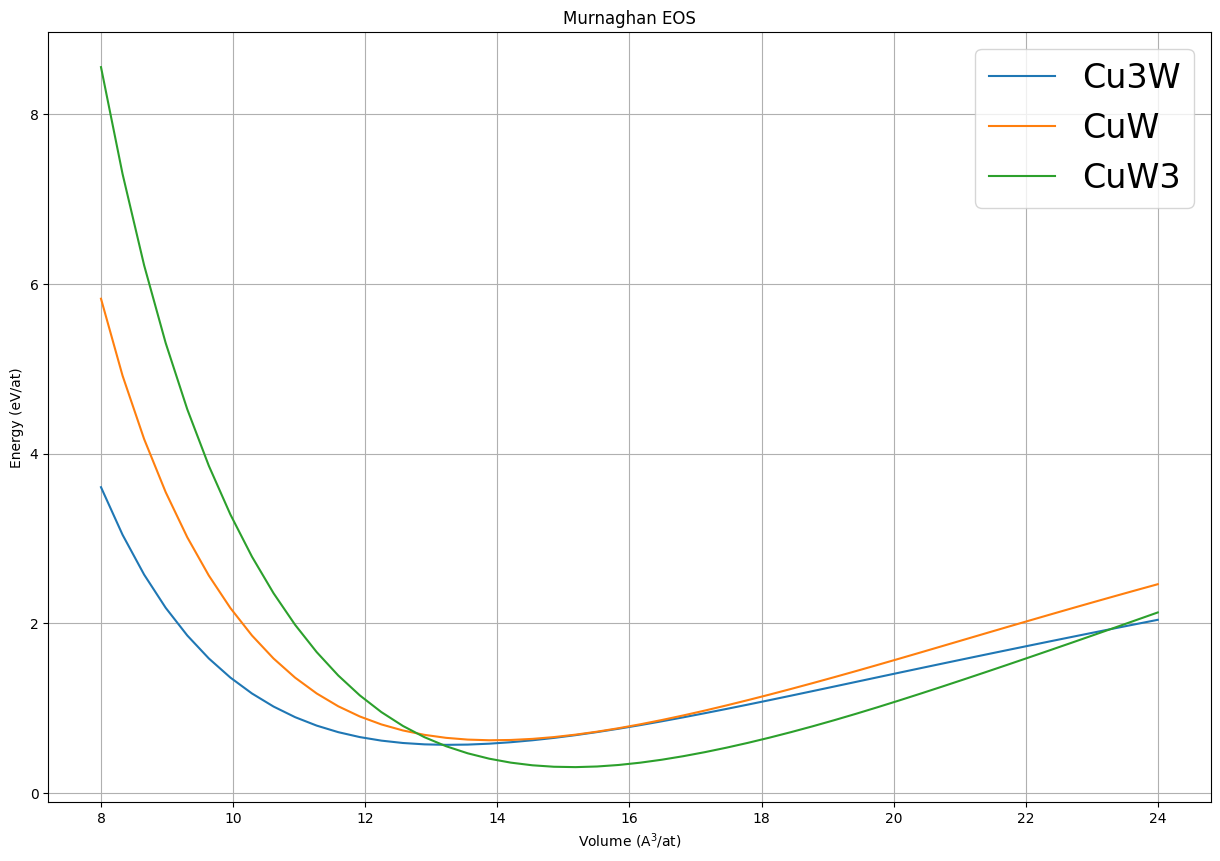

In [75]:
plt.figure(figsize=(15, 10))
plt.title("Murnaghan EOS")
for struc, struc_value in murn1.items(): 
    plt.plot(murn[struc]["vol"],murn[struc]["ene"],label=struc)
plt.xlabel("Volume (A$^3$/at)")
plt.ylabel("Energy (eV/at)");
#plt.ylim(en_opt-0.2,1)
plt.grid()
plt.legend(loc=0, prop={'size': 24})
plt.savefig("Energy_vs_Volume2.png")

print("Equilibrum lattice parameters and stresses of optimized structures")

### CuW - all components

In [76]:
from pprint import pprint

In [77]:
#eV_to_Ry=1/13.60569301
#Ry_to_eV= 13.60569301

In [78]:
# ACE calculations
from collections import defaultdict
file_path = './CuW_solid/CuW_fcc'
files = [os.path.join(file_path, file) for file in os.listdir(file_path)]
eop_fcc_ace = defaultdict(list)
for file in files:
    at = read(file, format='vasp')
    at.set_calculator(calc)
    ## optimize
    # optimizer=SpecialOptimizer(at)
    # at = optimizer.run()
    # at.set_calculator(calc)
    Cu_count = at.get_chemical_symbols().count('Cu')
    W_count = at.get_chemical_symbols().count('W')
    eop_fcc_ace["percent"].append(Cu_count/len(at))
    eop_fcc_ace["energy"].append((at.get_potential_energy()-Cu_count*E_refer_Cu-W_count*E_refer_W)/len(at))
#print(eop_fcc_ace["energy"])
eop_fcc_ace = pd.DataFrame.from_dict(eop_fcc_ace, orient='index').T
#print(eop_fcc_ace)

In [79]:
# ACE calculations
file_path = './CuW_solid/CuW_bcc'
files = [os.path.join(file_path, file) for file in os.listdir(file_path)]
eop_bcc_ace = defaultdict(list)
for file in files:
    at = read(file, format='vasp')
    at.set_calculator(calc)
    ## optimize
    # optimizer=SpecialOptimizer(at)
    # at = optimizer.run()
    # at.set_calculator(calc)
    Cu_count = at.get_chemical_symbols().count('Cu')
    W_count = at.get_chemical_symbols().count('W')
    eop_bcc_ace["percent"].append(Cu_count/len(at))
    eop_bcc_ace["energy"].append((at.get_potential_energy()-Cu_count*E_refer_Cu-W_count*E_refer_W)/len(at))
#print(eop_fcc_ace["energy"])
eop_bcc_ace = pd.DataFrame.from_dict(eop_bcc_ace, orient='index').T
#print(eop_fcc_ace)

/home/jiahaopan/.conda/envs/pace38_virtual/lib/python3.8/site-packages/ase-3.22.1-py3.8.egg/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)


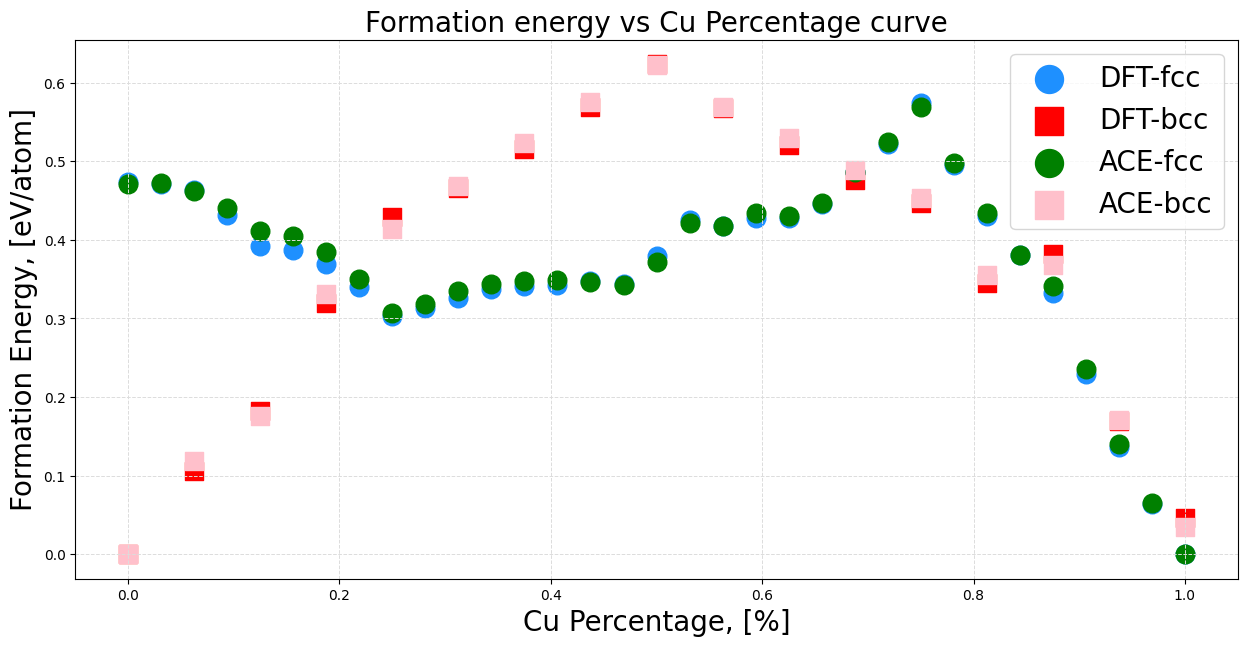

In [80]:
eop_fcc_dft = pd.read_csv("./data_dft/CuW_fcc_formation.csv",delimiter=" ",decimal=".",header=None,names=["percent","energy"])
eop_bcc_dft = pd.read_csv("./data_dft/CuW_bcc_formation.csv",delimiter=" ",decimal=".",header=None,names=["percent","energy"])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
plt.rcParams['font.size'] = '20'
ax.grid(c='gainsboro',ls='--',lw=0.7)


# plot E-percent curve
ax.set_title('Formation energy vs Cu Percentage curve',fontsize=20)

ax.scatter(eop_fcc_dft["percent"], eop_fcc_dft["energy"],  s=180, marker='o', c = 'dodgerblue', alpha=1,label='DFT-fcc')
ax.scatter(eop_bcc_dft["percent"], eop_bcc_dft["energy"],  s=180, marker='s', c = 'red', alpha=1,label='DFT-bcc')
ax.scatter(eop_fcc_ace["percent"], eop_fcc_ace["energy"],  s=180, marker='o', c = 'green', alpha=1,label='ACE-fcc')
ax.scatter(eop_bcc_ace["percent"], eop_bcc_ace["energy"],  s=180, marker='s', c = 'pink', alpha=1,label='ACE-bcc')

ax.set_xlabel('Cu Percentage, [%]',fontsize='20')
ax.set_ylabel('Formation Energy, [eV/atom]',fontsize='20')
ax.legend(loc='best',fontsize=20,markerscale=1.5)



